In [17]:
# Initial imports and enviroment setup
import gymnasium as gym
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
# SARSA Learning agent class
from collections import defaultdict


class SARSAAgent:
    def __init__(self, alpha, epsilon, gamma, get_possible_actions):
        self.get_possible_actions = get_possible_actions
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self._Q = defaultdict(lambda: defaultdict(lambda: 0))

    def get_Q(self, state, action):
        return self._Q[state][action]

    def set_Q(self, state, action, value):
        self._Q[state][action] = value

    # carryout SARSA updated based on the sample (S, A, R, S', A')
    def update(self, state, action, reward, next_state, next_action, done):
        if not done:
            td_error = reward + \
                       self.gamma * self.get_Q(next_state, next_action) - \
                       self.get_Q(state, action)
        else:
            td_error = reward - self.get_Q(state, action)

        new_value = self.get_Q(state, action) + self.alpha * td_error
        self.set_Q(state, action, new_value)

    # get argmax for q(s,a)
    def max_action(self, state):
        actions = self.get_possible_actions(state)
        best_action = []
        best_q_value = float("-inf")

        for action in actions:
            q_s_a = self.get_Q(state, action)
            if q_s_a > best_q_value:
                best_action = [action]
                best_q_value = q_s_a
            elif q_s_a == best_q_value:
                best_action.append(action)
        return np.random.choice(np.array(best_action))

    # choose action as per epsilon-greedy policy
    def get_action(self, state):
        actions = self.get_possible_actions(state)

        if len(actions) == 0:
            return None

        if np.random.random() < self.epsilon:
            a = np.random.choice(actions)
            return a
        else:
            a = self.max_action(state)
            return a

In [19]:
# training algorithm
def train_agent(env, agent, episode_cnt=10000, tmax=10000, anneal_eps=True):
    episode_rewards = []
    for i in range(episode_cnt):
        G = 0
        state, _ = env.reset()
        action = agent.get_action(state)
        for t in range(tmax):
            next_state, reward, done, _, _ = env.step(action)
            next_action = agent.get_action(next_state)
            agent.update(state, action, reward, next_state, next_action, done)
            G += reward
            if done:
                episode_rewards.append(G)
                # to reduce the exploration probability epsilon over the
                # training period.
                if anneal_eps:
                    agent.epsilon = agent.epsilon * 0.99
                break
            state = next_state
            action = next_action
    return np.array(episode_rewards)

In [20]:
# plot rewards
def plot_rewards(env_name, rewards, label):
    plt.title("env={}, Mean reward = {:.1f}".format(env_name,
                                                    np.mean(rewards[-20:])))
    plt.plot(rewards, label=label)
    plt.grid()
    plt.legend()
    plt.ylim(-300, 0)
    plt.show()

In [21]:
# helper function to print policy under Cliff world
def print_policy(env, agent):
    nR, nC = env._cliff.shape

    actions = '^>v<'

    for y in range(nR):
        for x in range(nC):
            if env._cliff[y, x]:
                print(" C ", end='')
            elif (y * nC + x) == env.start_state_index:
                print(" X ", end='')
            elif (y * nC + x) == nR * nC - 1:
                print(" T ", end='')
            else:
                print(" %s " %
                      actions[agent.max_action(y * nC + x)], end='')
        print()

In [22]:
# create cliff world environment
env = gym.make('CliffWalking-v0')
print(env.__doc__)

Will produce an error if ``step`` or ``render`` is called before ``reset``.

    No vector version of the wrapper exists.

    Example:
        >>> import gymnasium as gym
        >>> from gymnasium.wrappers import OrderEnforcing
        >>> env = gym.make("CartPole-v1", render_mode="human")
        >>> env = OrderEnforcing(env)
        >>> env.step(0)
        Traceback (most recent call last):
            ...
        gymnasium.error.ResetNeeded: Cannot call env.step() before calling env.reset()
        >>> env.render()
        Traceback (most recent call last):
            ...
        gymnasium.error.ResetNeeded: Cannot call `env.render()` before calling `env.reset()`, if this is an intended action, set `disable_render_order_enforcing=True` on the OrderEnforcer wrapper.
        >>> _ = env.reset()
        >>> env.render()
        >>> _ = env.step(0)
        >>> env.close()

    Change logs:
     * v0.22.0 - Initially added
     * v0.24.0 - Added order enforcing for the render function

In [23]:
env.action_space.n

np.int64(4)

In [24]:
# create a SARSA agent
agent = SARSAAgent(
            alpha=0.25,
            epsilon=0.2,
            gamma=0.99,
            get_possible_actions=lambda s : range(env.action_space.n)
        )

#train agent and get rewards for episodes
rewards = train_agent(env, agent, episode_cnt = 5000)

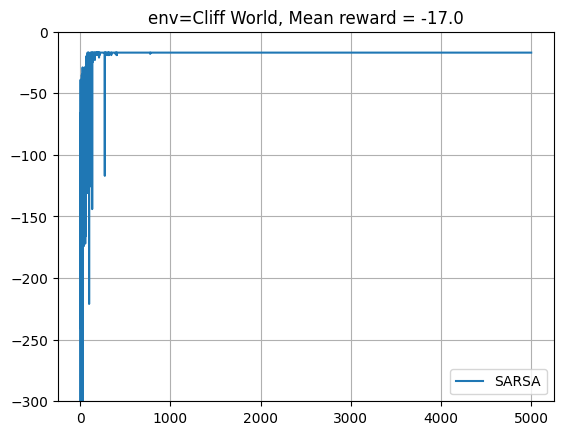

In [25]:
# plot rewards
plot_rewards("Cliff World",rewards, 'SARSA')